### Library Import

In [ ]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go


### Data Load

In [ ]:
data_path: str = "../../../data"

In [ ]:
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train")
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test")
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv"))
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [ ]:
train_df

,ID,target,_type
0,2023-01-01 00:00:00,2,train
1,2023-01-01 01:00:00,1,train
2,2023-01-01 02:00:00,1,train
3,2023-01-01 03:00:00,1,train
4,2023-01-01 04:00:00,2,train
...,...,...,...
8755,2023-12-31 19:00:00,1,train
8756,2023-12-31 20:00:00,1,train
8757,2023-12-31 21:00:00,0,train
8758,2023-12-31 22:00:00,2,train


In [ ]:
test_df

,ID,_type
0,2024-01-01 00:00:00,test
1,2024-01-01 01:00:00,test
2,2024-01-01 02:00:00,test
3,2024-01-01 03:00:00,test
4,2024-01-01 04:00:00,test
...,...,...
2787,2024-04-26 03:00:00,test
2788,2024-04-26 04:00:00,test
2789,2024-04-26 05:00:00,test
2790,2024-04-26 06:00:00,test


In [ ]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할당
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and 'ALL' in f and f.endswith(".csv")
]
file_names.append('HOURLY_MARKET-DATA_COINBASE-PREMIUM-INDEX.csv')

# 'NETWORK'가 포함된 파일 추가
network_files = [
    f for f in os.listdir(data_path) if 'NETWORK' in f and f.endswith(".csv")
]

# 'NETWORK' 파일들을 기존 file_names 리스트에 추가
file_names.extend(network_files)

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 43/43 [00:01<00:00, 31.31it/s]


### EDA (Explanatory Data Analysis)

In [ ]:
for c in df.columns:
    print(c)

ID
target
_type
hourly_market-data_funding-rates_all_exchange_funding_rates
hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations
hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations
hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd
hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd
hourly_market-data_liquidations_binance_all_symbol_long_liquidations
hourly_market-data_liquidations_binance_all_symbol_short_liquidations
hourly_market-data_liquidations_binance_all_symbol_long_liquidations_usd
hourly_market-data_liquidations_binance_all_symbol_short_liquidations_usd
hourly_market-data_liquidations_bitfinex_all_symbol_long_liquidations
hourly_market-data_liquidations_bitfinex_all_symbol_short_liquidations
hourly_market-data_liquidations_bitfinex_all_symbol_long_liquidations_usd
hourly_market-data_liquidations_bitfinex_all_symbol_short_liquidations_usd
hourly_market-data_liquidations_deribit_al

In [ ]:
# 모델에 사용할 컬럼, 컬럼의 rename rule을 미리 할당함
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close": "price_close",
    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume": "price_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "buy_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    "hourly_network-data_transactions-count_transactions_count_total":"transactions_count",
    "hourly_network-data_addresses-count_addresses_count_active": "active_count",
    "hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
    "hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
    "hourly_network-data_difficulty_difficulty" : "difficulty",
    "hourly_network-data_hashrate_hashrate" : "hashrate",
    "hourly_network-data_supply_supply_total": "supply_total",
    "hourly_network-data_supply_supply_new" : "supply_new",
    'hourly_network-data_utxo-count_utxo_count' : 'utxo-count'
}
df = df[cols_dict.keys()].rename(cols_dict, axis=1)
df.shape

(11552, 27)

In [ ]:
for c in df.columns:
    print(c)

ID
target
_type
coinbase_premium_gap
coinbase_premium_index
funding_rates
long_liquidations
long_liquidations_usd
short_liquidations
short_liquidations_usd
open_interest
price_close
price_volume
buy_ratio
buy_sell_ratio
buy_volume
sell_ratio
sell_volume
transactions_count
active_count
receiver_count
sender_count
difficulty
hashrate
supply_total
supply_new
utxo-count


결측치 처리

In [ ]:
# 타겟변수를 제외한 결측치 확인
df_drop = df.drop(columns='target')

# 결측치 확인
missing_data = df_drop.isnull().sum().sort_values()

# 결측치 비율 확인
missing_ratio = df_drop.isnull().mean().sort_values()

display(missing_data)
missing_ratio

,0
ID,0
_type,0
hashrate,0
sender_count,0
receiver_count,0
long_liquidations,0
long_liquidations_usd,0
short_liquidations,0
short_liquidations_usd,0
active_count,0


,0
ID,0.000000
_type,0.000000
hashrate,0.000000
sender_count,0.000000
receiver_count,0.000000
long_liquidations,0.000000
long_liquidations_usd,0.000000
short_liquidations,0.000000
short_liquidations_usd,0.000000
active_count,0.000000


In [ ]:
df = df.dropna(axis=1, how='all')
df_drop = df.drop(columns='target')
# 결측치 처리 - 선형 보간법
df_clear = df_drop.interpolate(method='linear', limit_direction='both')


# 다항 보간법
# df_clear = df_clear.interpolate(method='polynomial', order=2)

# 결측치 합계 확인
df_clear.isna().sum().sum()

<ipython-input-105-f223dcaaf51c>:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_clear = df_drop.interpolate(method='linear', limit_direction='both')


0

In [ ]:
df.update(df_clear)

In [ ]:
df_drop.update(df_clear)

In [ ]:
df.isna().sum()

,0
ID,0
target,2792
_type,0
coinbase_premium_gap,0
coinbase_premium_index,0
funding_rates,0
long_liquidations,0
long_liquidations_usd,0
short_liquidations,0
short_liquidations_usd,0


이상치 처리

In [ ]:
# # 결측치가 있는 열과 해당 열의 데이터 타입 확인
# missing_info = df.isnull().sum()  # 각 열의 결측치 개수 확인
# missing_cols = missing_info[missing_info > 0].index  # 결측치가 있는 열 추출

# for col in missing_cols:
#     print(f"Column: {col}, Missing Values: {missing_info[col]}, Data Type: {df[col].dtype}")

Column: target, Missing Values: 2792, Data Type: float64


In [ ]:
# df_drop = df.drop(["ID", 'target', "_type"], axis = 1)

In [ ]:
df_drop

,coinbase_premium_gap,coinbase_premium_index,funding_rates,long_liquidations,long_liquidations_usd,short_liquidations,short_liquidations_usd,open_interest,price_close,price_volume,...,sell_volume,transactions_count,active_count,receiver_count,sender_count,difficulty,hashrate,supply_total,supply_new,utxo-count
0,-9.86,-0.059650,0.005049,0.012000,197.51610,0.000000,0.00000,6.271344e+09,16536.747967,5516.420322,...,5.137537e+07,11457.0,67987,37752,37307,3.536407e+13,5.062917e+11,1.924871e+07,75.00,83308092.0
1,-8.78,-0.053047,0.005049,0.000000,0.00000,0.712000,11833.56104,6.288683e+09,16557.136536,4513.341881,...,2.401129e+07,5832.0,30593,20534,12342,3.536407e+13,1.687639e+11,1.924874e+07,25.00,83314883.0
2,-9.59,-0.057952,0.005049,0.000000,0.00000,0.000000,0.00000,6.286796e+09,16548.149805,4310.904314,...,2.340995e+07,5550.0,33897,19369,17737,3.536407e+13,3.375278e+11,1.924879e+07,50.00,83314090.0
3,-9.74,-0.058912,0.005067,0.593000,9754.76891,0.000000,0.00000,6.284575e+09,16533.632875,4893.417864,...,3.270773e+07,5245.0,32717,23799,11421,3.536407e+13,2.109549e+11,1.924882e+07,31.25,83326258.0
4,-10.14,-0.061373,0.006210,0.361000,5944.43714,0.000000,0.00000,6.291582e+09,16524.712159,5209.002297,...,3.193766e+07,6942.0,45176,31712,17320,3.536407e+13,2.953368e+11,1.924886e+07,43.75,83339168.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,-1.53,-0.002376,0.009411,0.710000,45484.20433,0.243500,15682.76464,1.486836e+10,42285.799905,1549.917518,...,2.553196e+08,10048.0,29250,13601,18154,8.810419e+13,3.153372e+11,1.968986e+07,12.50,179820708.0
11548,-11.73,-0.018268,0.009411,6.577208,420718.03779,0.146000,9419.65430,1.486836e+10,42285.799905,1549.917518,...,2.553196e+08,10048.0,56580,29096,31320,8.810419e+13,6.306744e+11,1.968986e+07,12.50,179833897.0
11549,1.85,0.002866,0.009411,1.797163,114902.59095,5.216490,337367.12807,1.486836e+10,42285.799905,1549.917518,...,2.553196e+08,10048.0,51858,22094,34083,8.810419e+13,6.306744e+11,1.968986e+07,12.50,179851249.0
11550,-2.05,-0.003184,0.009411,0.803000,51434.51531,1.656000,106931.54104,1.486836e+10,42285.799905,1549.917518,...,2.553196e+08,10048.0,36270,12668,26186,8.810419e+13,4.204496e+11,1.968986e+07,12.50,179852452.0


In [ ]:
# from sklearn.ensemble import IsolationForest

# # Isolation Forest 모델 생성
# isolation_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

# # 모델 훈련 및 이상치 탐지 (결과: -1은 이상치, 1은 정상치)
# iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

# # df_drop의 모든 열에 대해 fit_predict 실행 (숫자형 데이터만 적용)
# df_drop['anomaly'] = iso_forest.fit_predict(df_drop)

# # 이상치 확인 (-1은 이상치로 분류된 데이터)
# print("Detected outliers:")
# print(df_drop[df_drop['anomaly'] == -1])

# # 이상치를 NaN으로 대체
# df_cleaned = df_drop.copy()
# df_cleaned.loc[df_cleaned['anomaly'] == -1, df_cleaned.columns != 'anomaly'] = np.nan

Detected outliers:
       coinbase_premium_gap  coinbase_premium_index  funding_rates  \
1                     -8.78               -0.053047       0.005049   
27                    -5.28               -0.031689       0.002524   
45                    -6.69               -0.039922       0.007034   
89                    -4.18               -0.024744       0.005989   
92                    -3.14               -0.018683       0.006083   
...                     ...                     ...            ...   
11538                -24.57               -0.037968       0.009411   
11540                  5.71                0.008812       0.009411   
11541                 -3.96               -0.006120       0.009411   
11543                -13.90               -0.021551       0.009411   
11545                 -6.21               -0.009642       0.009411   

       long_liquidations  long_liquidations_usd  short_liquidations  \
1               0.000000           0.000000e+00            0.712000  

In [ ]:
# print(df_cleaned['anomaly'].value_counts())

anomaly
 1    10396
-1     1156
Name: count, dtype: int64


In [ ]:
# print(df_cleaned[df_cleaned['anomaly'] == -1])

       coinbase_premium_gap  coinbase_premium_index  funding_rates  \
1                       NaN                     NaN            NaN   
27                      NaN                     NaN            NaN   
45                      NaN                     NaN            NaN   
89                      NaN                     NaN            NaN   
92                      NaN                     NaN            NaN   
...                     ...                     ...            ...   
11538                   NaN                     NaN            NaN   
11540                   NaN                     NaN            NaN   
11541                   NaN                     NaN            NaN   
11543                   NaN                     NaN            NaN   
11545                   NaN                     NaN            NaN   

       long_liquidations  long_liquidations_usd  short_liquidations  \
1                    NaN                    NaN                 NaN   
27               

In [ ]:
# # 'anomaly' 열 제거
# df_cleaned = df_cleaned.drop(columns=['anomaly'])

# # df.update(df_cleaned) -> NaN값은 업데이트 안됨
# df.loc[df_cleaned.index, df_cleaned.columns] = df_cleaned

In [ ]:
df.isna().sum()

,0
ID,0
target,2792
_type,0
coinbase_premium_gap,1156
coinbase_premium_index,1156
funding_rates,1156
long_liquidations,1156
long_liquidations_usd,1156
short_liquidations,1156
short_liquidations_usd,1156


In [ ]:
# 'ID'와 '_type' 열을 제외하고 모든 수치형 열에 대해 상관관계 계산
eda_df = df.loc[df["_type"] == "train"]
numeric_columns = eda_df.select_dtypes(include=['int64', 'float64']).columns
correlation = eda_df[numeric_columns].corr()

# target과의 상관관계를 기준으로 정렬
target_corr = correlation['target'].abs().sort_values(ascending=False)

# 상위 20개 특성 출력
print("Target과 상관관계가 높은 상위 20개:")
print(target_corr.head(20))


Target과 상관관계가 높은 상위 20개:
target                    1.000000
buy_sell_ratio            0.021334
price_volume              0.020822
buy_ratio                 0.018561
sell_ratio                0.018561
sell_volume               0.017258
coinbase_premium_index    0.016741
open_interest             0.016103
funding_rates             0.015718
coinbase_premium_gap      0.015098
price_close               0.013891
buy_volume                0.013518
receiver_count            0.013116
long_liquidations         0.010390
long_liquidations_usd     0.010339
active_count              0.006253
short_liquidations        0.003487
difficulty                0.002804
supply_total              0.002775
utxo-count                0.002221
Name: target, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
eda_df.columns

Index(['ID', 'target', '_type', 'coinbase_premium_gap',
       'coinbase_premium_index', 'funding_rates', 'long_liquidations',
       'long_liquidations_usd', 'short_liquidations', 'short_liquidations_usd',
       'open_interest', 'price_close', 'price_volume', 'buy_ratio',
       'buy_sell_ratio', 'buy_volume', 'sell_ratio', 'sell_volume',
       'transactions_count', 'active_count', 'receiver_count', 'sender_count',
       'difficulty', 'hashrate', 'supply_total', 'supply_new', 'utxo-count'],
      dtype='object')

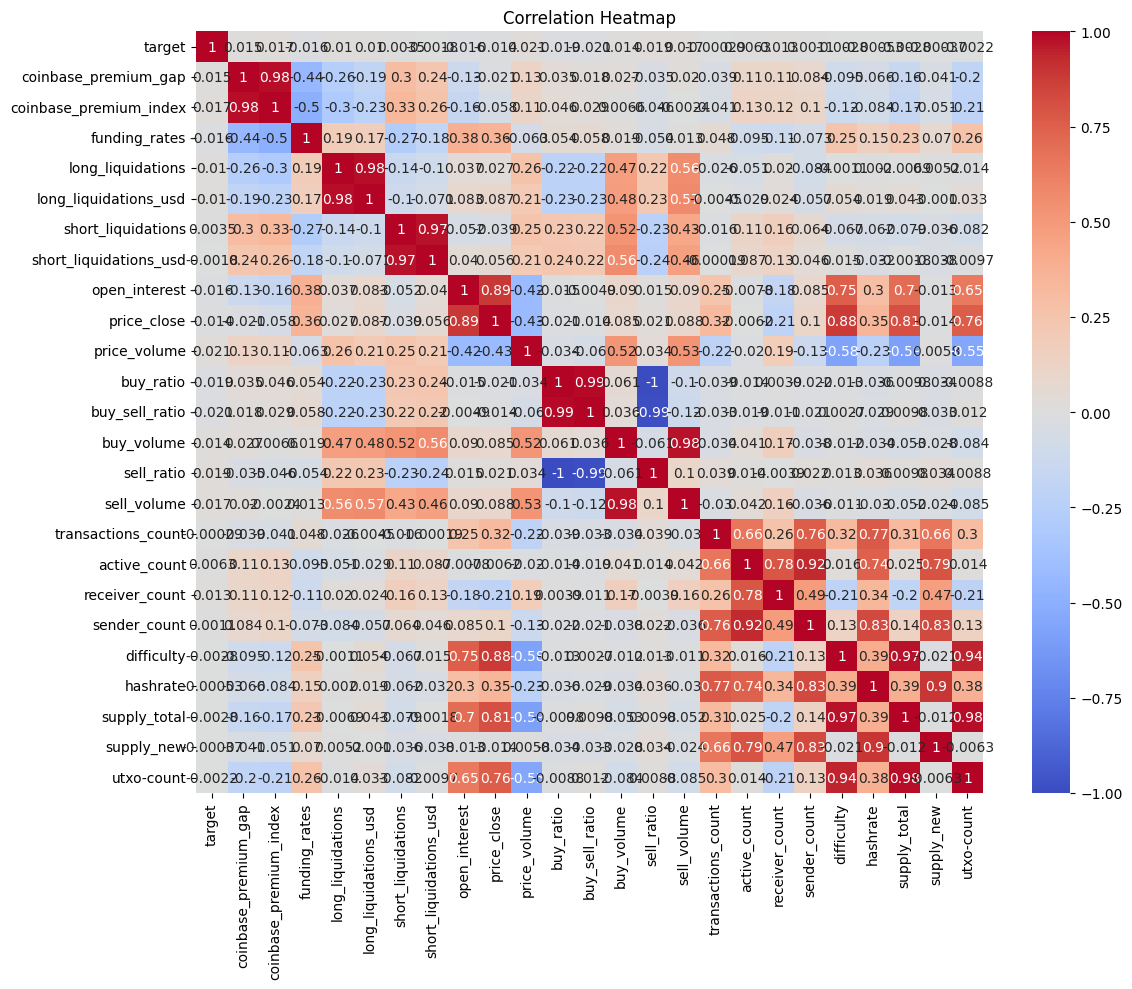

In [ ]:
# 히트맵 생성
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


<Figure size 1600x2000 with 0 Axes>

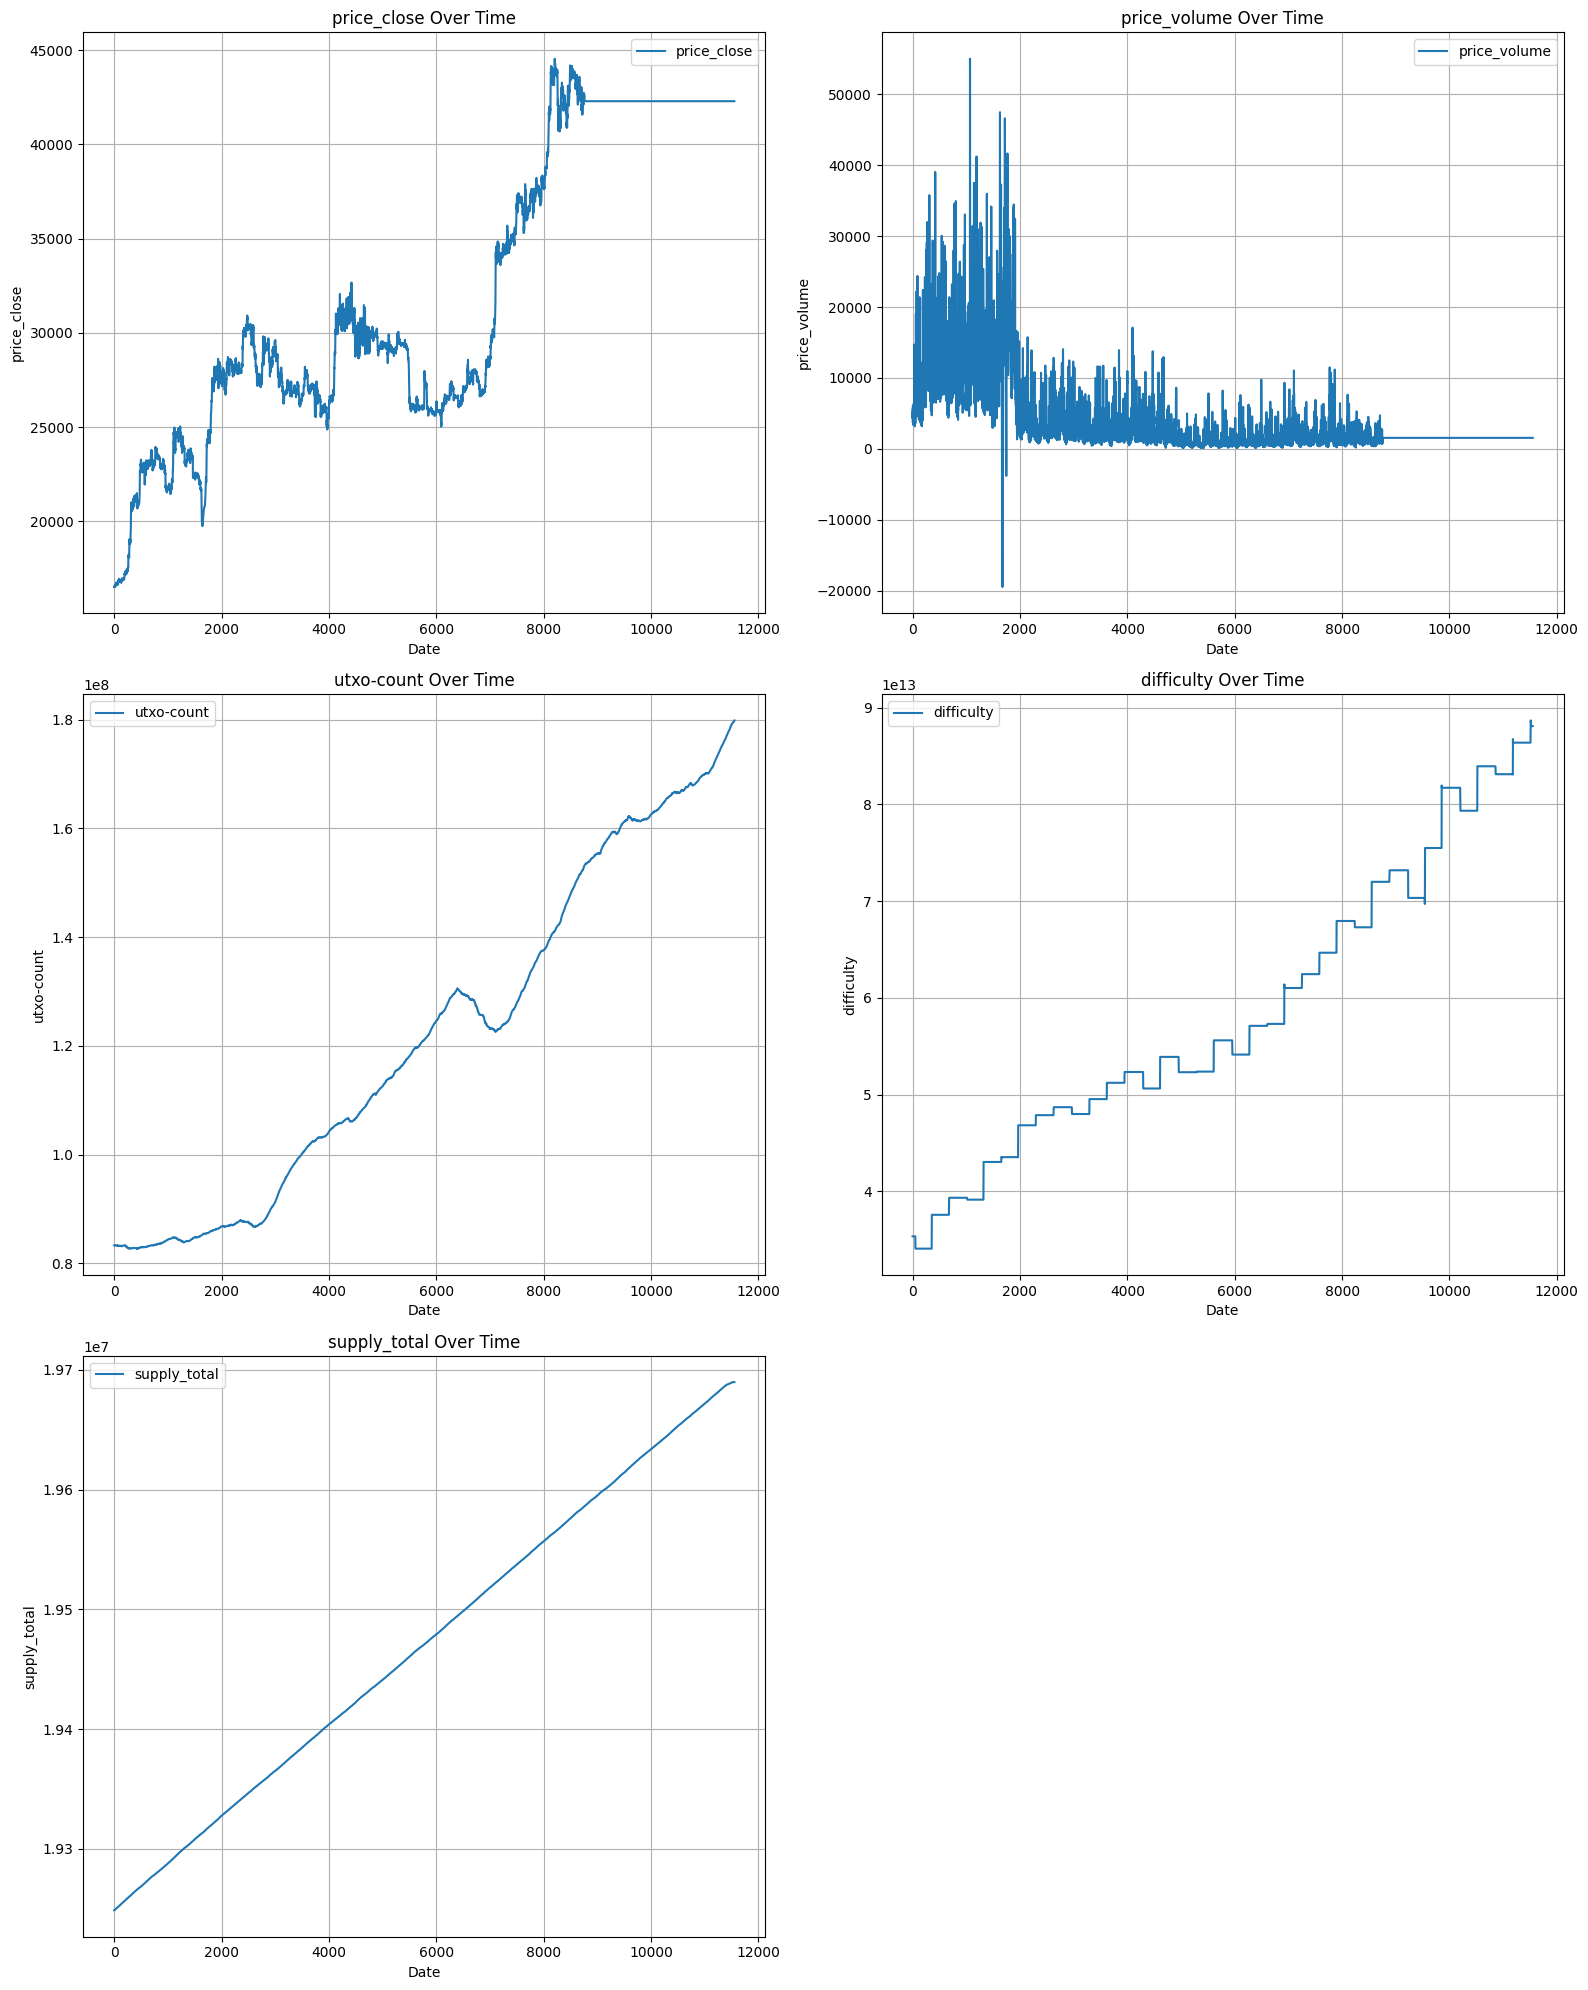

In [ ]:
plt.figure(figsize=(16, 20))

# 시각화할 컬럼 선택
columns = ['price_close', 'price_volume', 'utxo-count', 'difficulty', 'supply_total']

# 시각화 설정
plt.figure(figsize=(16, 20))

# 각 컬럼별로 서브플롯 생성 및 그래프 그리기
for i, col in enumerate(columns, 1):
    plt.subplot(3, 2, i)
    plt.plot(df.index, df[col], label=col)
    plt.title(f'{col} Over Time')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.grid(True)
    plt.legend()

# 그래프 간격 조정 및 레이아웃 조정
plt.tight_layout()
plt.show()

<Figure size 1600x2000 with 0 Axes>

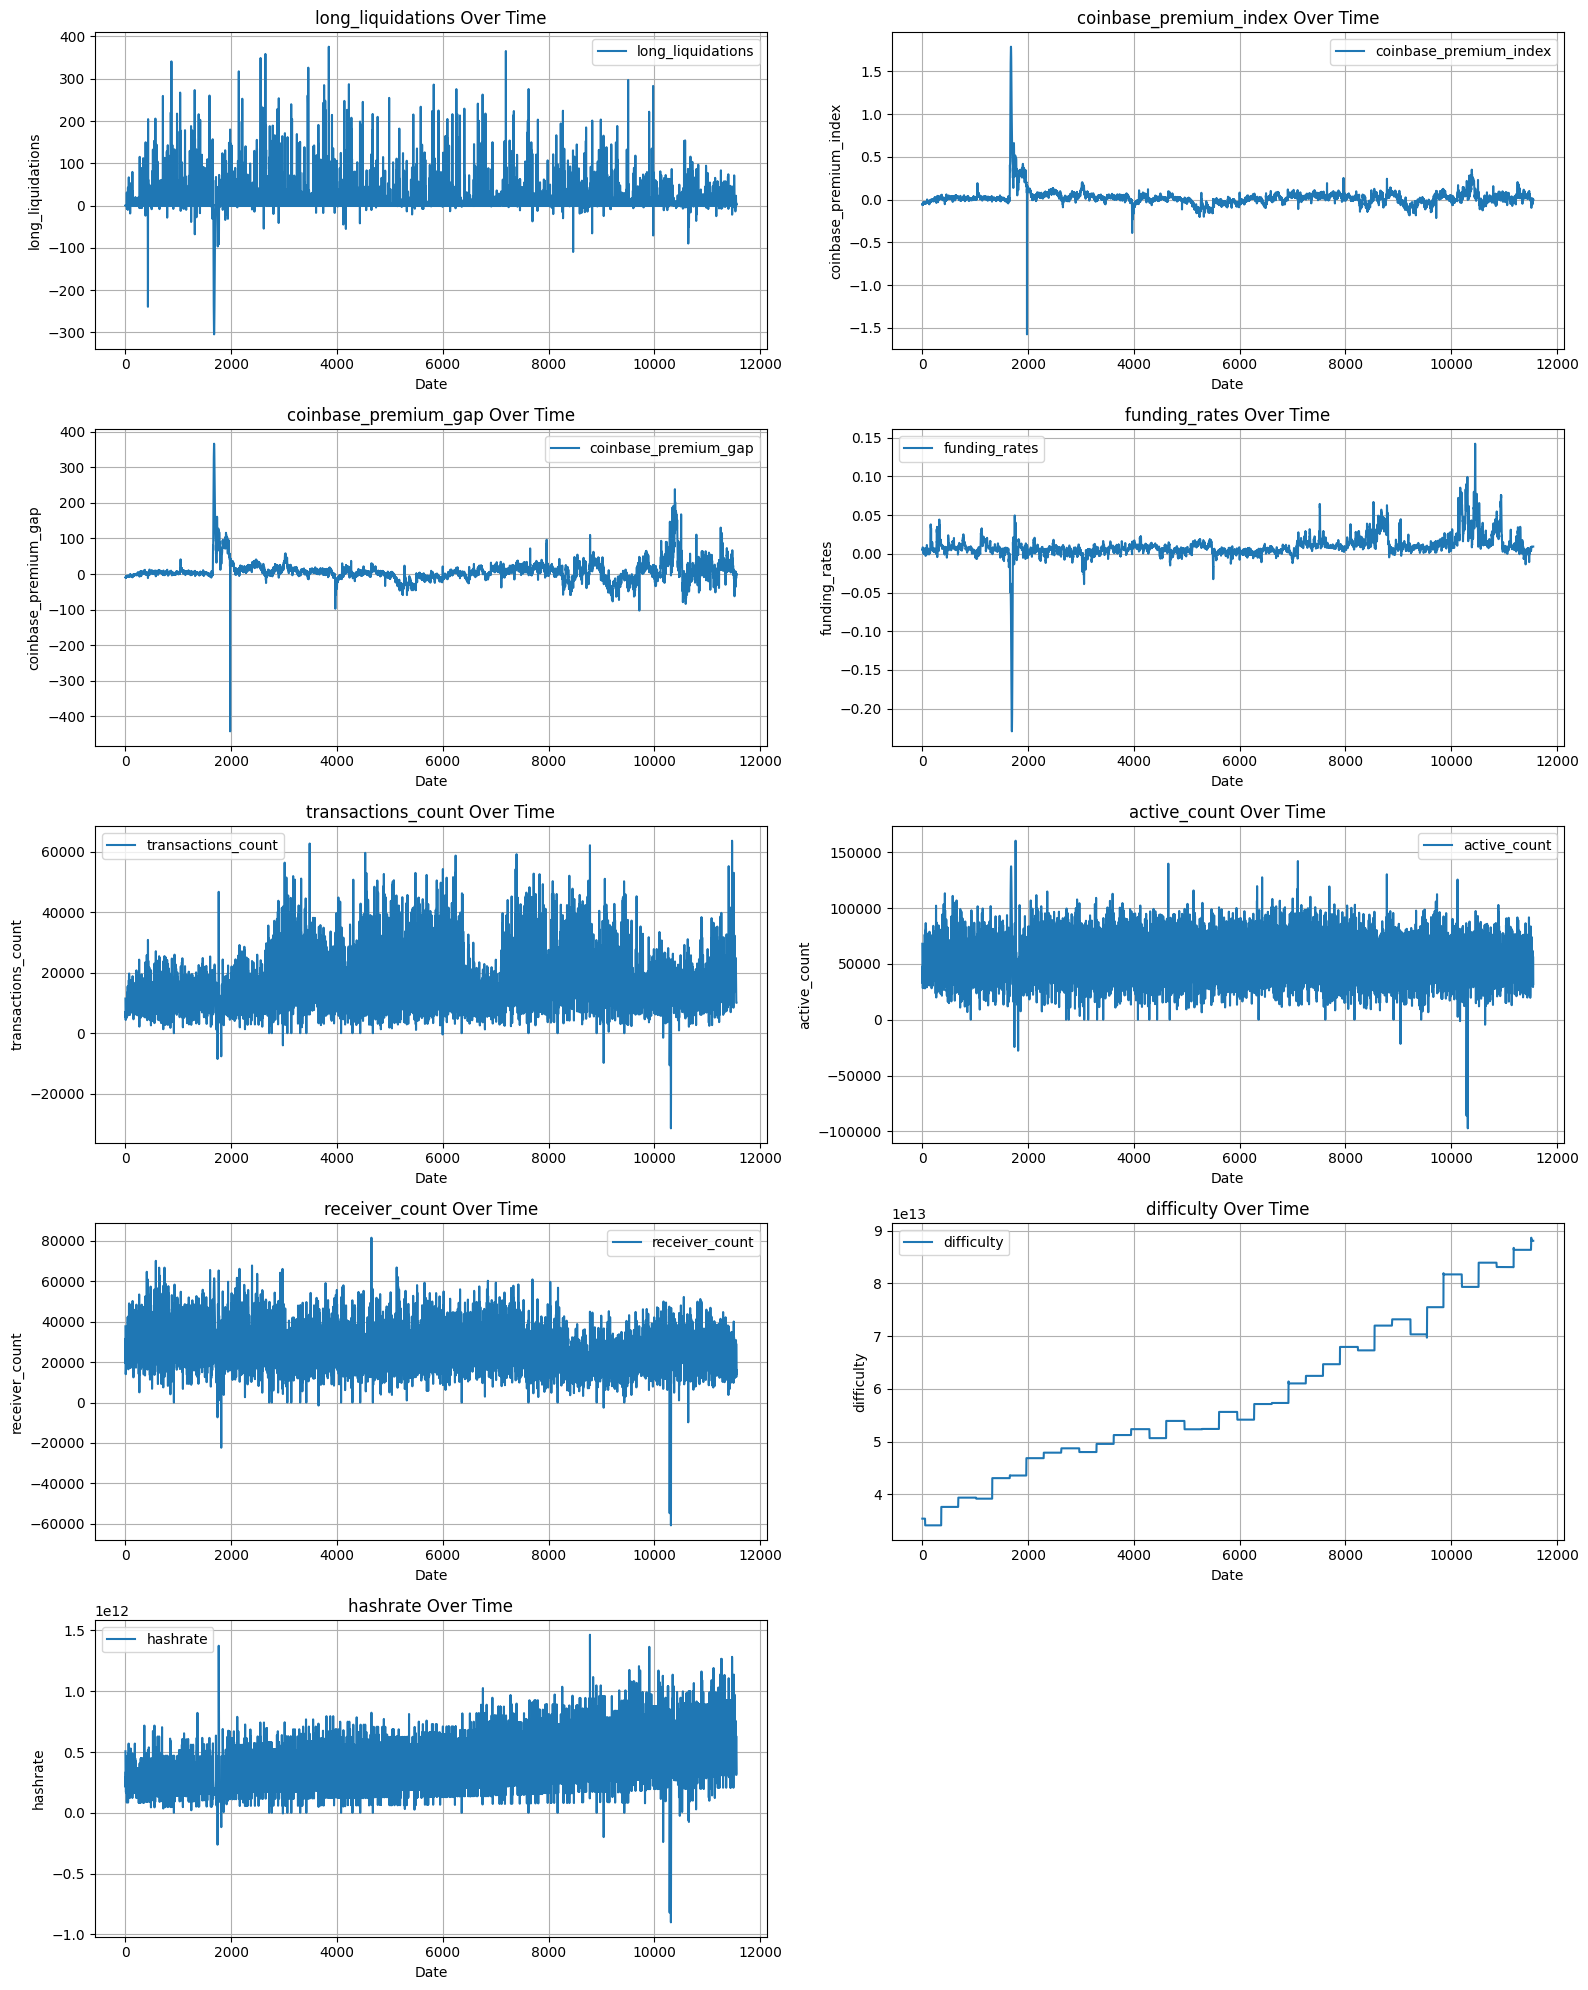

In [ ]:
plt.figure(figsize=(16, 20))

# 시각화할 컬럼 선택
columns = ['long_liquidations', 'coinbase_premium_index', 'coinbase_premium_gap', 'funding_rates', 'transactions_count', 'active_count', 'receiver_count', 'difficulty', 'hashrate']

# 시각화 설정
plt.figure(figsize=(16, 20))

# 각 컬럼별로 서브플롯 생성 및 그래프 그리기
for i, col in enumerate(columns, 1):
    plt.subplot(5, 2, i)
    plt.plot(df.index, df[col], label=col)
    plt.title(f'{col} Over Time')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.grid(True)
    plt.legend()

# 그래프 간격 조정 및 레이아웃 조정
plt.tight_layout()
plt.show()

### Feature engineering

In [ ]:
# 가격 변동량
df = df.assign(price_change = df["price_close"].diff())

# 순매수량/순매도량, 매수/매도 비율, 롱/숏 청산 차이, 롱/숏 청산 usd 차이
df = df.assign(volume_diff=df["buy_volume"] - df["sell_volume"],
               buy_sell_volume_ratio=df["buy_volume"] / (df["sell_volume"] + 1),
                 liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
               liquidation_usd_diff=df["long_liquidations_usd"] - df["short_liquidations_usd"])

In [ ]:
# 이동평균(moving average)
df = df.assign(MA5= df['price_close'].rolling(window=5).mean(),
               MA10= df['price_close'].rolling(window=10).mean(),
               MA20= df['price_close'].rolling(window=20).mean(),
               stddev= df['price_close'].rolling(window=20).std())


In [ ]:
# 볼린저 밴드
df = df.assign(upper_band= df['MA20'] + (df['stddev'] * 2),
               lower_band= df['MA20'] - (df['stddev'] * 2))

In [ ]:
# category, continuous 열을 따로 할당해둠
# category_cols: List[str] = ["liquidation_diffg", "liquidation_usd_diffg", "volume_diffg"]
# conti_cols: List[str] = [_ for _ in cols_dict.values() if _ not in ["ID", "target", "_type"]] + [
#     "buy_sell_volume_ratio",
#     "liquidation_diff",
#     "liquidation_usd_diff",
#     "volume_diff",
# ]

In [ ]:
# def shift_feature(
#     df: pd.DataFrame,
#     conti_cols: List[str],
#     intervals: List[int],
# ) -> List[pd.Series]:
#     """
#     연속형 변수의 shift feature 생성
#     Args:
#         df (pd.DataFrame)
#         conti_cols (List[str]): continuous colnames
#         intervals (List[int]): shifted intervals
#     Return:
#         List[pd.Series]
#     """
#     df_shift_dict = [
#         df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
#         for conti_col in conti_cols
#         for interval in intervals
#     ]
#     return df_shift_dict

# # 최대 24시간의 shift 피쳐를 계산
# shift_list = shift_feature(
#     df=df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 24)]
# )

In [ ]:
# # concat 하여 df 에 할당
# df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)


In [ ]:
# df.isna().sum()

,0
ID,0
target,2792
_type,0
coinbase_premium_gap,0
coinbase_premium_index,0
funding_rates,0
long_liquidations,0
long_liquidations_usd,0
short_liquidations,0
short_liquidations_usd,0


다시 결측치 처리

In [ ]:
# # 'target' 열을 제외한 데이터프레임 생성
# df_drop = df.drop(columns='target')

# # 결측치 처리
# df_clear = df_drop.interpolate(method='linear', limit_direction='both')

# df_clear.update(df_clear)

# print(df_clear.isna().sum().sum())

0


<ipython-input-124-a6e01895c2bb>:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_clear = df_drop.interpolate(method='linear', limit_direction='both')


In [ ]:
# df.update(df_clear)

In [ ]:
print(df.isna().sum())

ID                           0
target                    2792
_type                        0
coinbase_premium_gap         0
coinbase_premium_index       0
funding_rates                0
long_liquidations            0
long_liquidations_usd        0
short_liquidations           0
short_liquidations_usd       0
open_interest                0
price_close                  0
price_volume                 0
buy_ratio                    0
buy_sell_ratio               0
buy_volume                   0
sell_ratio                   0
sell_volume                  0
transactions_count           0
active_count                 0
receiver_count               0
sender_count                 0
difficulty                   0
hashrate                     0
supply_total                 0
supply_new                   0
utxo-count                   0
price_change                 0
volume_diff                  0
buy_sell_volume_ratio        0
liquidation_diff             0
liquidation_usd_diff         0
MA5     

In [ ]:
# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])



---



### Model Training

In [ ]:
# 데이터 분할
x_train, x_valid, y_train, y_valid = train_test_split(
    train_df.drop(["target", "ID"], axis = 1),
    train_df["target"].astype(int),
    test_size=0.2,
    random_state=42,
    stratify=train_df["target"].astype(int)
)

print("x_train length:", len(x_train))
print("y_train length:", len(y_train))
print("x_valid length:", len(x_valid))
print("y_valid length:", len(y_valid))


x_train length: 7008
y_train length: 7008
x_valid length: 1752
y_valid length: 1752


In [ ]:
params = {
    "objective": "multi:softprob",  # 다중 클래스 분류
    "num_class": 4,                 # 클래스 개수
    "learning_rate": 0.05,          # 학습률
    "max_depth": 6,                 # 트리의 최대 깊이
    "n_estimators": 30,             # 부스팅을 몇 번 할지
    "random_state": 42,             # 재현성을 위한 시드 값
    "eval_metric": "mlogloss"       # 평가 지표 설정
}

# XGBoost 모델 학습
xgb_model = xgb.XGBClassifier(**params)

xgb_model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)]) # early_stopping_rounds=10

# 예측
y_valid_pred = xgb_model.predict_proba(x_valid)
y_valid_pred_class = xgb_model.predict(x_valid)

# score check
accuracy = accuracy_score(y_valid, y_valid_pred_class)
auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")

print(f"acc: {accuracy}, auroc: {auroc}")

[0]	validation_0-mlogloss:1.36907
[1]	validation_0-mlogloss:1.35299
[2]	validation_0-mlogloss:1.33784
[3]	validation_0-mlogloss:1.32390
[4]	validation_0-mlogloss:1.31105
[5]	validation_0-mlogloss:1.29901
[6]	validation_0-mlogloss:1.28752
[7]	validation_0-mlogloss:1.27671
[8]	validation_0-mlogloss:1.26650
[9]	validation_0-mlogloss:1.25695
[10]	validation_0-mlogloss:1.24784
[11]	validation_0-mlogloss:1.23939
[12]	validation_0-mlogloss:1.23145
[13]	validation_0-mlogloss:1.22421
[14]	validation_0-mlogloss:1.21717
[15]	validation_0-mlogloss:1.21059
[16]	validation_0-mlogloss:1.20476
[17]	validation_0-mlogloss:1.19904
[18]	validation_0-mlogloss:1.19343
[19]	validation_0-mlogloss:1.18806
[20]	validation_0-mlogloss:1.18300
[21]	validation_0-mlogloss:1.17850
[22]	validation_0-mlogloss:1.17415
[23]	validation_0-mlogloss:1.16999
[24]	validation_0-mlogloss:1.16618
[25]	validation_0-mlogloss:1.16273
[26]	validation_0-mlogloss:1.15931
[27]	validation_0-mlogloss:1.15608
[28]	validation_0-mlogloss:1.1

In [ ]:
# performance 체크후 전체 학습 데이터로 다시 재학습
xgb_model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)])
print(f"acc: {accuracy}, auroc: {auroc}")

[0]	validation_0-mlogloss:1.36907
[1]	validation_0-mlogloss:1.35299
[2]	validation_0-mlogloss:1.33784
[3]	validation_0-mlogloss:1.32390
[4]	validation_0-mlogloss:1.31105
[5]	validation_0-mlogloss:1.29901
[6]	validation_0-mlogloss:1.28752
[7]	validation_0-mlogloss:1.27671
[8]	validation_0-mlogloss:1.26650
[9]	validation_0-mlogloss:1.25695
[10]	validation_0-mlogloss:1.24784
[11]	validation_0-mlogloss:1.23939
[12]	validation_0-mlogloss:1.23145
[13]	validation_0-mlogloss:1.22421
[14]	validation_0-mlogloss:1.21717
[15]	validation_0-mlogloss:1.21059
[16]	validation_0-mlogloss:1.20476
[17]	validation_0-mlogloss:1.19904
[18]	validation_0-mlogloss:1.19343
[19]	validation_0-mlogloss:1.18806
[20]	validation_0-mlogloss:1.18300
[21]	validation_0-mlogloss:1.17850
[22]	validation_0-mlogloss:1.17415
[23]	validation_0-mlogloss:1.16999
[24]	validation_0-mlogloss:1.16618
[25]	validation_0-mlogloss:1.16273
[26]	validation_0-mlogloss:1.15931
[27]	validation_0-mlogloss:1.15608
[28]	validation_0-mlogloss:1.1

### Inference

In [ ]:
y_valid_pred

array([[0.09761455, 0.38863537, 0.4070533 , 0.10669681],
       [0.15420027, 0.29674578, 0.41946328, 0.12959063],
       [0.12064749, 0.28860897, 0.42022902, 0.17051448],
       ...,
       [0.13685904, 0.39261085, 0.3205867 , 0.14994337],
       [0.20410992, 0.3379716 , 0.30221453, 0.15570396],
       [0.09877087, 0.38315055, 0.41400608, 0.1040725 ]], dtype=float32)

In [ ]:
# predict
y_test_pred_class = xgb_model.predict(test_df.drop(["target", "ID"], axis=1))

### Output File Save

In [ ]:
# output file 할당후 save
submission_df = submission_df.assign(target = y_test_pred_class)
submission_df.to_csv("output.csv", index=False)